<a href="https://colab.research.google.com/github/nmansour67/skills-introduction-to-github/blob/main/Oman_UAE_Bilateral_Trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import re
import os
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
pd.set_option('display.float_format', '{:.2f}'.format)

print('Libraries loaded')

Libraries loaded


In [2]:
# ============================================
# CONFIGURATION - CHANGE ONLY THIS
# ============================================
PARTNER_COUNTRY = 'UAE'  # Change this to: 'Somalia', 'UAE', 'Yemen', etc.
# ============================================

In [5]:
# ============================================
# CONFIGURATION - CHANGE ONLY THIS
# ============================================
PARTNER_COUNTRY = 'UAE'  # Change to: 'Somalia', 'UAE', 'Yemen', etc.
# ============================================

print(f'Analyzing Oman-{PARTNER_COUNTRY} Trade')
print('='*60)

# Check for CSV files
csv_files = [f for f in os.listdir() if f.endswith('.csv')]

if len(csv_files) == 0:
    print('⚠ ERROR: No CSV files found!')
    print('Please upload your files first.')
else:
    print(f'Found {len(csv_files)} CSV files\n')

    all_data = []

    for filename in csv_files:
        # Skip files that don't match the partner country
        if PARTNER_COUNTRY.lower() not in filename.lower():
            continue

        print(f'Processing: {filename}')

        try:
            df_raw = pd.read_csv(filename, encoding='latin1', header=[0, 1])
        except Exception as e:
            print(f'  ✗ Error reading file: {e}')
            continue

        # Determine trade type from filename
        filename_lower = filename.lower()
        if 'exp to' in filename_lower and 're-exp' not in filename_lower:
            trade_type = 'export'
        elif 'imp' in filename_lower and 're-exp' not in filename_lower:
            trade_type = 'import'
        elif 're-exp' in filename_lower:
            trade_type = 'reexport'
        else:
            trade_type = 'other'

        # Determine measure type
        if 'qty' in filename_lower or 'products' in filename_lower:
            measure = 'quantity'
        else:
            measure = 'value'

        print(f'  Trade type: {trade_type}, Measure: {measure}')

        df = df_raw.copy()
        new_columns = []

        for col in df.columns:
            # Combine both levels of the multi-index column
            col_str = str(col[0]).lower() + ' ' + str(col[1]).lower()

            # More flexible matching
            if 'product' in col_str and 'code' in col_str:
                new_columns.append('product_code')
            elif 'product' in col_str and 'label' in col_str:
                new_columns.append('product_label')
            elif 'existing' in col_str or 'potential' in col_str:
                new_columns.append('product_label')
            elif 'hs' in col_str and 'code' in col_str:
                new_columns.append('product_code')
            elif 'description' in col_str or 'commodity' in col_str:
                new_columns.append('product_label')
            else:
                # Extract year from column
                year_match = re.search(r'20\d{2}', col_str)
                if year_match:
                    year = year_match.group()
                    new_columns.append(f'year_{year}')
                else:
                    new_columns.append(f'col_{len(new_columns)}')

        df.columns = new_columns

        # Check if we have the required columns
        if 'product_code' not in df.columns or 'product_label' not in df.columns:
            print(f'  ✗ Missing product columns. Found: {df.columns[:5].tolist()}...')
            print(f'  Skipping this file.')
            continue

        # Reshape to long format
        id_cols = ['product_code', 'product_label']
        year_cols = [col for col in df.columns if col.startswith('year_')]

        if not year_cols:
            print(f'  ✗ No year columns found')
            continue

        df_long = df.melt(
            id_vars=id_cols,
            value_vars=year_cols,
            var_name='year',
            value_name='trade_value'
        )

        df_long['year'] = df_long['year'].str.replace('year_', '').astype(int)
        df_long['trade_type'] = trade_type
        df_long['measure'] = measure
        df_long['partner_country'] = PARTNER_COUNTRY

        # Set exporter and importer
        if trade_type in ['export', 'reexport']:
            df_long['exporter'] = 'Oman'
            df_long['importer'] = PARTNER_COUNTRY
        else:
            df_long['exporter'] = PARTNER_COUNTRY
            df_long['importer'] = 'Oman'

        df_long['trade_value'] = pd.to_numeric(df_long['trade_value'], errors='coerce')
        df_long = df_long.dropna(subset=['trade_value', 'product_code'])

        # Remove rows where trade_value is 0
        df_long = df_long[df_long['trade_value'] > 0]

        print(f'  ✓ Loaded: {len(df_long):,} rows')
        all_data.append(df_long)

    if not all_data:
        print(f'\n⚠ ERROR: No valid data loaded for {PARTNER_COUNTRY}')
    else:
        df_combined = pd.concat(all_data, ignore_index=True)
        print(f'\n✓ SUCCESS: Combined {len(df_combined):,} rows for Oman-{PARTNER_COUNTRY} trade')
        print(f'  Years covered: {df_combined["year"].min()} - {df_combined["year"].max()}')
        print(f'  Trade types: {df_combined["trade_type"].unique().tolist()}')

Analyzing Oman-UAE Trade
Found 6 CSV files

Processing: Oman Imp to UAE_Qty_Products_HS6 10Yrs.csv
  Trade type: import, Measure: quantity
  ✓ Loaded: 184 rows
Processing: Oman Re-Exp to UAE HS6 10Yrs_Value.csv
  Trade type: reexport, Measure: value
  ✓ Loaded: 135 rows
Processing: Oman Imp to UAE HS6 10Yrs_Value.csv
  Trade type: import, Measure: value
  ✓ Loaded: 196 rows
Processing: Oman Exp to UAE_Qty_Products_HS6 10Yrs.csv
  Trade type: export, Measure: quantity
  ✓ Loaded: 172 rows
Processing: Oman Re-Exp to UAE_Qty_Products_HS6 10Yrs.csv
  Trade type: reexport, Measure: quantity
  ✓ Loaded: 143 rows
Processing: Oman Exp to UAE HS6 10Yrs_Value (1).csv
  Trade type: export, Measure: value
  ✗ Missing product columns. Found: ['col_0', 'col_1', 'year_2050', 'col_3', 'year_2005']...
  Skipping this file.

✓ SUCCESS: Combined 830 rows for Oman-UAE trade
  Years covered: 2014 - 2024
  Trade types: ['import', 'reexport', 'export']


In [17]:
print('\nCLEANING DATA...')
print('='*60)

df_clean = df_combined.copy()
initial = len(df_clean)

# Remove missing values
df_clean = df_clean.dropna(subset=['year', 'product_code', 'trade_value'])

# Remove zero or negative values
df_clean = df_clean[df_clean['trade_value'] > 0]

# Ensure proper data types
df_clean['year'] = df_clean['year'].astype(int)
df_clean['product_code'] = df_clean['product_code'].astype(str).str.strip()
df_clean['product_label'] = df_clean['product_label'].astype(str).str.strip()

# Remove duplicates
df_clean = df_clean.drop_duplicates()

removed = initial - len(df_clean)
print(f'✓ Removed {removed:,} invalid/duplicate rows')
print(f'✓ Clean data: {len(df_clean):,} rows')
print(f'✓ Columns: {list(df_clean.columns)}')
print(f'\nFirst few rows:')
df_clean.head()


CLEANING DATA...
✓ Removed 0 invalid/duplicate rows
✓ Clean data: 830 rows
✓ Columns: ['product_code', 'product_label', 'year', 'trade_value', 'trade_type', 'measure', 'partner_country', 'exporter', 'importer']

First few rows:


,product_code,product_label,year,trade_value,trade_type,measure,partner_country,exporter,importer
0,'252310,Cement clinkers,2014,791568.00,import,quantity,UAE,UAE,Oman
1,'271012,"Light oils and preparations, of petroleum or b...",2014,280525.00,import,quantity,UAE,UAE,Oman
2,'252329,"Portland cement (excl. white, whether or not a...",2014,3183943.00,import,quantity,UAE,UAE,Oman
3,'271019,"Medium oils and preparations, of petroleum or ...",2014,45163.00,import,quantity,UAE,UAE,Oman
4,'853922,Filament lamps of a power <= 200 W and for a v...,2014,21.00,import,quantity,UAE,UAE,Oman


In [16]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_clean)

https://docs.google.com/spreadsheets/d/1F3bP2c6OW9VJ3On39KLUEQNY1TdeRIyFb--YuJQwiSc/edit#gid=0


In [18]:
print(f'\nOMAN-{PARTNER_COUNTRY} TRADE OVERVIEW')
print('='*60)

year_min = df_clean['year'].min()
year_max = df_clean['year'].max()
print(f'Period: {year_min} - {year_max}')

df_value = df_clean[df_clean['measure'] == 'value']
total_trade = df_value['trade_value'].sum()

print(f'Total Trade Value: ${total_trade:,.0f}')
print(f'Mean: ${df_value["trade_value"].mean():,.0f}')
print(f'Median: ${df_value["trade_value"].median():,.0f}')

print('\nTrade Types:')
print(df_value['trade_type'].value_counts())

print(f'\nUnique Products: {df_clean["product_code"].nunique()}')


OMAN-UAE TRADE OVERVIEW
Period: 2014 - 2024
Total Trade Value: $25,468,980,000
Mean: $76,945,559
Median: $30,542,000

Trade Types:
trade_type
import      196
reexport    135
Name: count, dtype: int64

Unique Products: 69


In [10]:
# CLEAN DATA
print('CLEANING DATA...')
print('='*60)

df_clean = df_combined.copy()
initial = len(df_clean)

df_clean = df_clean.dropna(subset=['year', 'product_code', 'trade_value'])
df_clean = df_clean[df_clean['trade_value'] > 0]
df_clean['year'] = df_clean['year'].astype(int)
df_clean['product_code'] = df_clean['product_code'].astype(str).str.strip()
df_clean['product_label'] = df_clean['product_label'].astype(str).str.strip()
df_clean = df_clean.drop_duplicates()

removed = initial - len(df_clean)
print(f'✓ Removed {removed:,} invalid rows')
print(f'✓ Clean data: {len(df_clean):,} rows')

# OVERVIEW
print(f'\n\nOMAN-{PARTNER_COUNTRY} TRADE OVERVIEW')
print('='*60)

year_min = df_clean['year'].min()
year_max = df_clean['year'].max()
print(f'Period: {year_min} - {year_max}')

df_value = df_clean[df_clean['measure'] == 'value']
total_trade = df_value['trade_value'].sum()

print(f'\nTotal Trade Value: ${total_trade:,.0f}')
print(f'Mean: ${df_value["trade_value"].mean():,.0f}')
print(f'Median: ${df_value["trade_value"].median():,.0f}')

print('\nTrade Types:')
print(df_value['trade_type'].value_counts())

print(f'\nUnique Products: {df_clean["product_code"].nunique()}')

# Show sample data
print('\nSample data:')
df_clean.head(10)

CLEANING DATA...
✓ Removed 0 invalid rows
✓ Clean data: 830 rows


OMAN-UAE TRADE OVERVIEW
Period: 2014 - 2024

Total Trade Value: $25,468,980,000
Mean: $76,945,559
Median: $30,542,000

Trade Types:
trade_type
import      196
reexport    135
Name: count, dtype: int64

Unique Products: 69

Sample data:


,product_code,product_label,year,trade_value,trade_type,measure,partner_country,exporter,importer
0,'252310,Cement clinkers,2014,791568.00,import,quantity,UAE,UAE,Oman
1,'271012,"Light oils and preparations, of petroleum or b...",2014,280525.00,import,quantity,UAE,UAE,Oman
2,'252329,"Portland cement (excl. white, whether or not a...",2014,3183943.00,import,quantity,UAE,UAE,Oman
3,'271019,"Medium oils and preparations, of petroleum or ...",2014,45163.00,import,quantity,UAE,UAE,Oman
4,'853922,Filament lamps of a power <= 200 W and for a v...,2014,21.00,import,quantity,UAE,UAE,Oman
5,'851718,Telephone sets (excl. line telephone sets with...,2014,41.00,import,quantity,UAE,UAE,Oman
6,'100199,"Wheat and meslin (excl. seed for sowing, and d...",2014,1905.00,import,quantity,UAE,UAE,Oman
7,'261800,"Granulated slag ""slag sand"" from the manufactu...",2014,36582.00,import,quantity,UAE,UAE,Oman
8,'170199,Cane or beet sugar and chemically pure sucrose...,2014,80702.00,import,quantity,UAE,UAE,Oman
9,'230230,"Bran, sharps and other residues of wheat, whet...",2014,20033.00,import,quantity,UAE,UAE,Oman


TRADE BALANCE ANALYSIS
Oman Total Exports to UAE: $5,793,900,000
Oman Total Imports from UAE: $19,675,080,000
Trade Balance: $-13,881,180,000
Status: Oman has DEFICIT with UAE


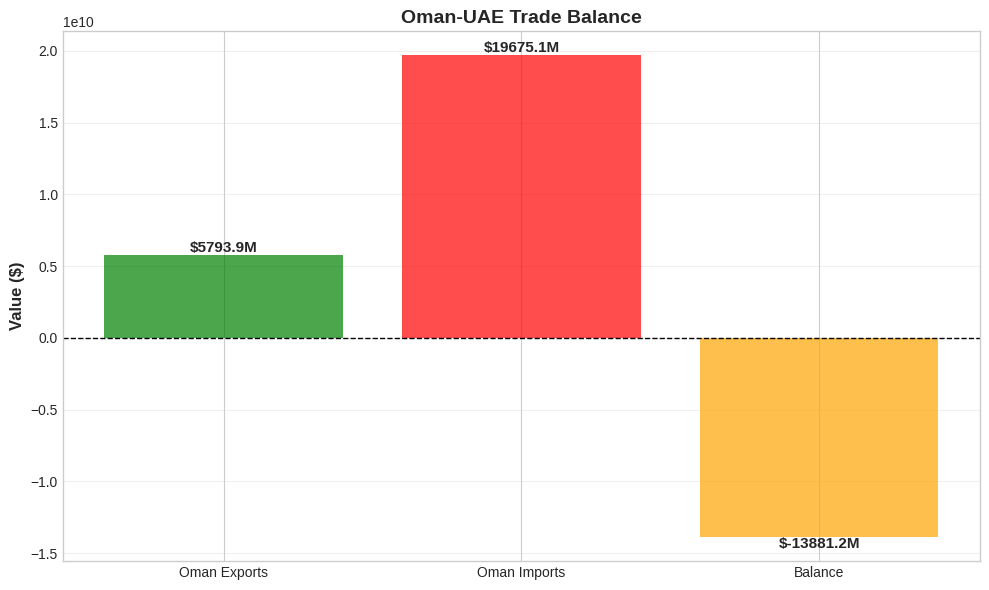

In [11]:
df_value = df_clean[df_clean['measure'] == 'value']

exports_df = df_value[df_value['trade_type'].isin(['export', 'reexport'])]
imports_df = df_value[df_value['trade_type'] == 'import']

oman_exports = exports_df['trade_value'].sum()
oman_imports = imports_df['trade_value'].sum()
balance = oman_exports - oman_imports

print('TRADE BALANCE ANALYSIS')
print('='*60)
print(f'Oman Total Exports to {PARTNER_COUNTRY}: ${oman_exports:,.0f}')
print(f'Oman Total Imports from {PARTNER_COUNTRY}: ${oman_imports:,.0f}')
print(f'Trade Balance: ${balance:,.0f}')

if balance > 0:
    print(f'Status: Oman has SURPLUS with {PARTNER_COUNTRY}')
else:
    print(f'Status: Oman has DEFICIT with {PARTNER_COUNTRY}')

fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Oman Exports', 'Oman Imports', 'Balance']
values = [oman_exports, oman_imports, balance]
colors_bar = ['green', 'red', 'blue' if balance > 0 else 'orange']

ax.bar(categories, values, color=colors_bar, alpha=0.7)
ax.set_ylabel('Value ($)', fontweight='bold', fontsize=12)
ax.set_title(f'Oman-{PARTNER_COUNTRY} Trade Balance', fontsize=14, fontweight='bold')
ax.axhline(0, color='black', linestyle='--', linewidth=1)

for i, v in enumerate(values):
    va_pos = 'bottom' if v > 0 else 'top'
    ax.text(i, v, f'${v/1e6:.1f}M', ha='center', va=va_pos,
            fontsize=11, fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [15]:
# ============================================================================
# SUMMARY TABLE
# ============================================================================
print(f'\n\nYEAR-BY-YEAR SUMMARY')
print('='*80)

# Safely extract values for each trade type
exports_vals = yearly_pivot['export'].values if 'export' in yearly_pivot.columns else np.zeros(len(yearly_pivot))
imports_vals = yearly_pivot['import'].values if 'import' in yearly_pivot.columns else np.zeros(len(yearly_pivot))
reexports_vals = yearly_pivot['reexport'].values if 'reexport' in yearly_pivot.columns else np.zeros(len(yearly_pivot))

summary = pd.DataFrame({
    'Year': yearly_pivot.index,
    'Exports': exports_vals,
    'Imports': imports_vals,
    'Re-exports': reexports_vals,
    'Total Trade': yearly_pivot.sum(axis=1).values,
    'Balance': balance_df['trade_balance'].values
})

# Format currency columns
for col in ['Exports', 'Imports', 'Re-exports', 'Total Trade', 'Balance']:
    summary[f'{col}_fmt'] = summary[col].apply(lambda x: f'${x:,.0f}')

summary['Balance Status'] = summary['Balance'].apply(lambda x: 'Surplus ✓' if x > 0 else 'Deficit ✗')

# Display formatted table
display_summary = summary[['Year', 'Exports_fmt', 'Imports_fmt', 'Re-exports_fmt',
                           'Total Trade_fmt', 'Balance_fmt', 'Balance Status']].copy()
display_summary.columns = ['Year', 'Exports', 'Imports', 'Re-exports',
                           'Total Trade', 'Balance', 'Status']

print(display_summary.to_string(index=False))

# Additional summary statistics
print(f'\n\nKEY INSIGHTS:')
print('='*80)
print(f'Total Exports (all years): ${exports_vals.sum():,.0f}')
print(f'Total Imports (all years): ${imports_vals.sum():,.0f}')
print(f'Total Re-exports (all years): ${reexports_vals.sum():,.0f}')
print(f'Overall Trade Balance: ${balance_df["trade_balance"].sum():,.0f}')
print(f'Years with Surplus: {(summary["Balance"] > 0).sum()}')
print(f'Years with Deficit: {(summary["Balance"] < 0).sum()}')

# Calculate trade intensity
total_oman_trade = exports_vals.sum() + reexports_vals.sum()
total_partner_trade = imports_vals.sum()
print(f'\nOman total outflow to {PARTNER_COUNTRY}: ${total_oman_trade:,.0f}')
print(f'{PARTNER_COUNTRY} total outflow to Oman: ${total_partner_trade:,.0f}')

if total_oman_trade > total_partner_trade:
    ratio = total_oman_trade / total_partner_trade if total_partner_trade > 0 else float('inf')
    print(f'Oman exports {ratio:.2f}x more to {PARTNER_COUNTRY} than it imports')
else:
    ratio = total_partner_trade / total_oman_trade if total_oman_trade > 0 else float('inf')
    print(f'Oman imports {ratio:.2f}x more from {PARTNER_COUNTRY} than it exports')

print('\n✓ Comprehensive Time Series Analysis Complete!')



YEAR-BY-YEAR SUMMARY
 Year Exports        Imports     Re-exports    Total Trade         Balance    Status
 2014      $0             $0    $69,764,000    $69,764,000     $69,764,000 Surplus ✓
 2015      $0 $2,288,597,000 $1,739,016,000 $4,027,613,000   $-549,581,000 Deficit ✗
 2016      $0 $1,680,154,000   $186,997,000 $1,867,151,000 $-1,493,157,000 Deficit ✗
 2017      $0 $1,703,175,000    $44,225,000 $1,747,400,000 $-1,658,950,000 Deficit ✗
 2018      $0 $1,730,089,000   $588,239,000 $2,318,328,000 $-1,141,850,000 Deficit ✗
 2019      $0 $1,293,277,000   $550,629,000 $1,843,906,000   $-742,648,000 Deficit ✗
 2020      $0 $1,527,566,000   $454,099,000 $1,981,665,000 $-1,073,467,000 Deficit ✗
 2021      $0 $2,434,143,000   $597,550,000 $3,031,693,000 $-1,836,593,000 Deficit ✗
 2022      $0 $2,578,570,000   $689,307,000 $3,267,877,000 $-1,889,263,000 Deficit ✗
 2023      $0 $2,396,776,000   $874,074,000 $3,270,850,000 $-1,522,702,000 Deficit ✗
 2024      $0 $2,042,733,000             $

## 8. Unit Value & Terms of Trade Analysis-Section A:


UNIT VALUE & TERMS OF TRADE ANALYSIS

Average Unit Values by Year and Trade Type:
trade_type  import  reexport
year                        
2014           NaN   5953.98
2015        211.60   7983.74
2016        151.58    558.00
2017        157.13  30462.18
2018        185.92  13286.60
2019        170.13   7679.31
2020        276.21   2793.47
2021        341.03   6421.13
2022        730.50   4831.66
2023        599.16   1634.67

Unit Value Index (Base Year = 100):
trade_type  import  reexport
year                        
2014           NaN    100.00
2015        211.60    134.10
2016        151.60      9.40
2017        157.10    511.60
2018        185.90    223.20
2019        170.10    129.00
2020        276.20     46.90
2021        341.00    107.80
2022        730.50     81.20
2023        599.20     27.50


GROWTH DECOMPOSITION (CAGR):
------------------------------------------------------------
    Type  Value CAGR  Quantity CAGR  Price CAGR
  Import        0.29         -11.95       13

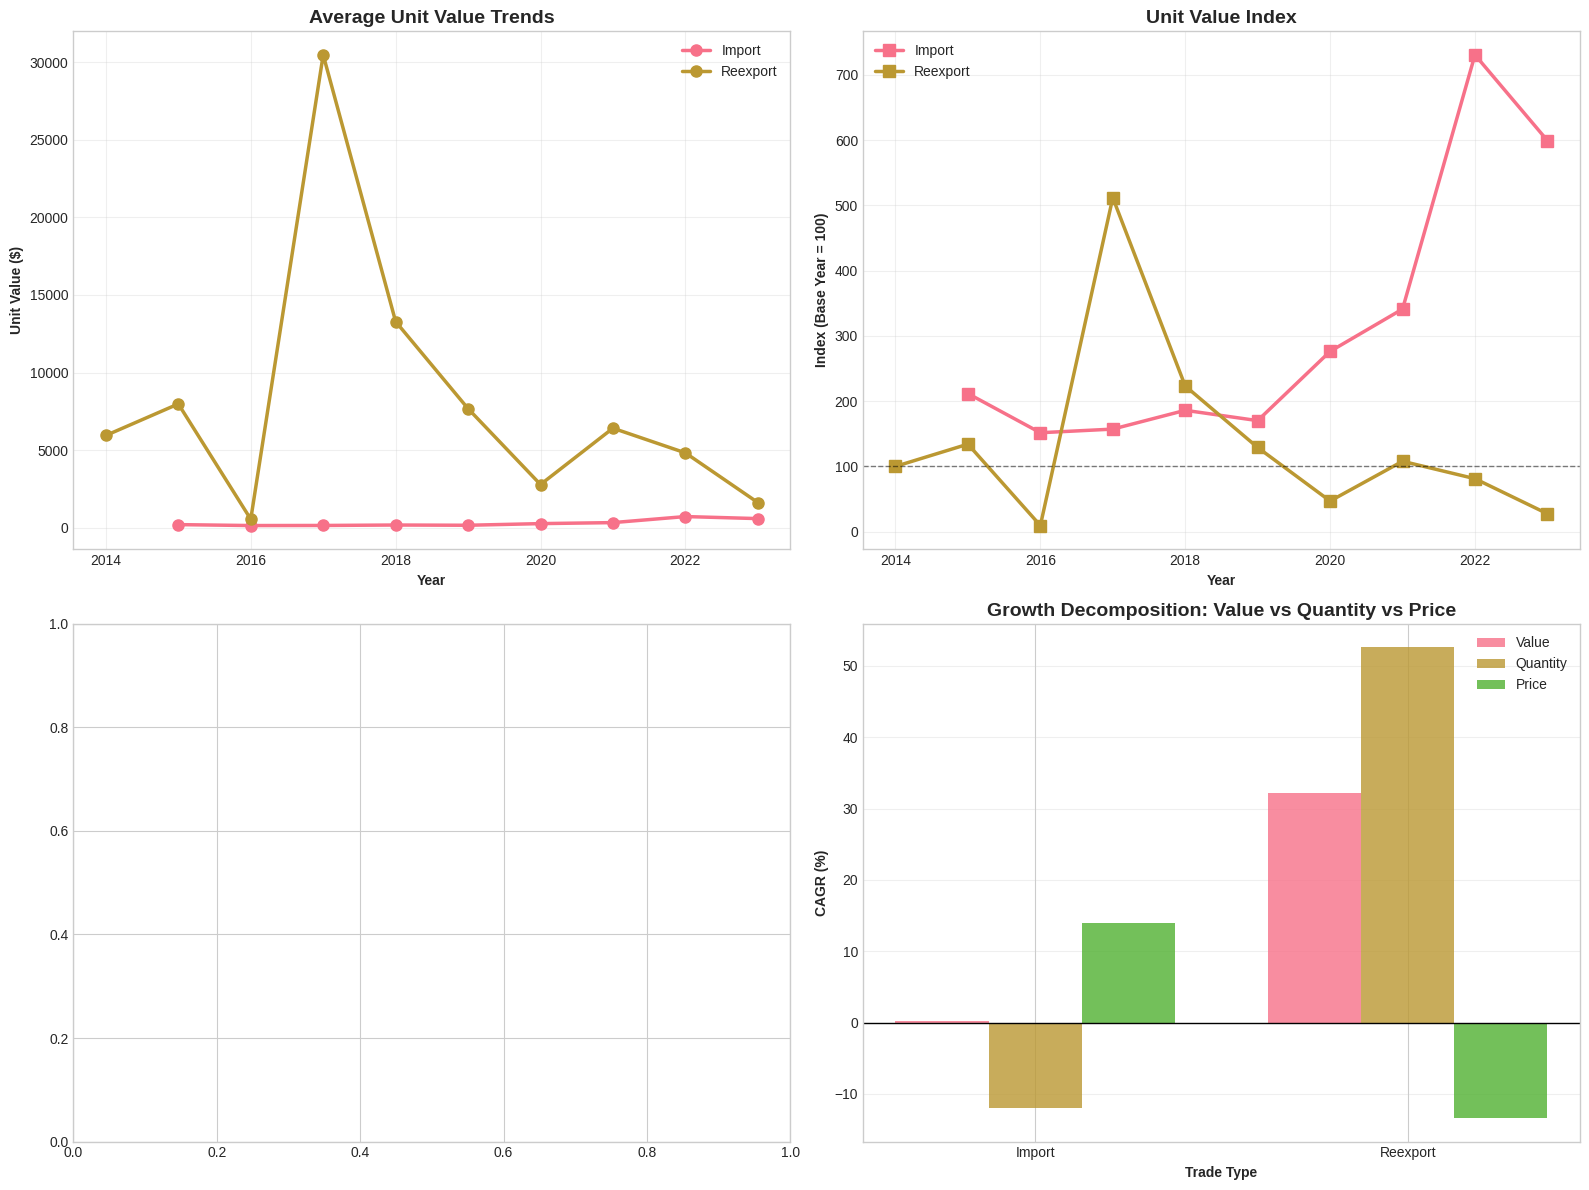


✓ Unit Value & Terms of Trade Analysis Complete!


In [19]:
# =============================================================================
# UNIT VALUE & TERMS OF TRADE ANALYSIS
# =============================================================================
print('\n' + '='*80)
print('UNIT VALUE & TERMS OF TRADE ANALYSIS')
print('='*80)

# Filter for data with both value and quantity
df_both = df_clean[df_clean['measure'].isin(['value', 'quantity'])].copy()

# Create separate dataframes for value and quantity
df_val = df_clean[df_clean['measure'] == 'value'].copy()
df_qty = df_clean[df_clean['measure'] == 'quantity'].copy()

# Merge value and quantity by year, product, and trade type
unit_value_data = df_val.merge(
    df_qty,
    on=['year', 'product_code', 'product_label', 'trade_type', 'exporter', 'importer'],
    suffixes=('_val', '_qty')
)

# Calculate Unit Value (price proxy)
unit_value_data['unit_value'] = unit_value_data['trade_value_val'] / unit_value_data['trade_value_qty']
unit_value_data = unit_value_data[unit_value_data['unit_value'] > 0]  # Remove invalid values

# Aggregate by year and trade type
uv_by_year = unit_value_data.groupby(['year', 'trade_type']).agg({
    'unit_value': 'mean',
    'trade_value_val': 'sum',
    'trade_value_qty': 'sum'
}).reset_index()

# Calculate weighted average unit value
uv_by_year['weighted_uv'] = uv_by_year['trade_value_val'] / uv_by_year['trade_value_qty']

print('\nAverage Unit Values by Year and Trade Type:')
uv_pivot = uv_by_year.pivot(index='year', columns='trade_type', values='weighted_uv')
print(uv_pivot.round(2))

# Calculate Unit Value Index (base year = first year)
uv_index = uv_pivot.copy()
for col in uv_index.columns:
    base_value = uv_index[col].iloc[0]
    if base_value > 0:
        uv_index[col] = (uv_index[col] / base_value) * 100

print('\nUnit Value Index (Base Year = 100):')
print(uv_index.round(1))

# Calculate Terms of Trade (Export UVI / Import UVI)
if 'export' in uv_index.columns and 'import' in uv_index.columns:
    tot = (uv_index['export'] / uv_index['import']) * 100
    tot_change = tot.iloc[-1] - tot.iloc[0]

    print(f'\n\nTERMS OF TRADE ANALYSIS:')
    print('-'*60)
    print(f'Base Year ToT: 100.0')
    print(f'Latest Year ToT: {tot.iloc[-1]:.1f}')
    print(f'Change: {tot_change:+.1f} points')

    if tot_change > 0:
        print(f'✓ IMPROVING - Oman can buy {abs(tot_change):.1f}% more imports with same exports')
    else:
        print(f'✗ DETERIORATING - Oman needs {abs(tot_change):.1f}% more exports for same imports')

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Unit Value Trends
for trade_type in uv_pivot.columns:
    axes[0, 0].plot(uv_pivot.index, uv_pivot[trade_type],
                    marker='o', linewidth=2.5, label=trade_type.capitalize(), markersize=8)
axes[0, 0].set_xlabel('Year', fontweight='bold')
axes[0, 0].set_ylabel('Unit Value ($)', fontweight='bold')
axes[0, 0].set_title('Average Unit Value Trends', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Unit Value Index
for trade_type in uv_index.columns:
    axes[0, 1].plot(uv_index.index, uv_index[trade_type],
                    marker='s', linewidth=2.5, label=trade_type.capitalize(), markersize=8)
axes[0, 1].axhline(100, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].set_xlabel('Year', fontweight='bold')
axes[0, 1].set_ylabel('Index (Base Year = 100)', fontweight='bold')
axes[0, 1].set_title('Unit Value Index', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Terms of Trade
if 'export' in uv_index.columns and 'import' in uv_index.columns:
    colors_tot = ['green' if x >= 100 else 'red' for x in tot.values]
    axes[1, 0].bar(tot.index, tot.values, color=colors_tot, alpha=0.7, edgecolor='black')
    axes[1, 0].axhline(100, color='black', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Year', fontweight='bold')
    axes[1, 0].set_ylabel('ToT Index (Base = 100)', fontweight='bold')
    axes[1, 0].set_title('Terms of Trade', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    for i, (year, val) in enumerate(zip(tot.index, tot.values)):
        axes[1, 0].text(year, val, f'{val:.1f}', ha='center',
                       va='bottom' if val >= 100 else 'top', fontsize=9)

# Plot 4: Value vs Quantity Growth Comparison
growth_comparison = []
for trade_type in ['export', 'import', 'reexport']:
    type_data = uv_by_year[uv_by_year['trade_type'] == trade_type]
    if len(type_data) > 1:
        val_growth = ((type_data['trade_value_val'].iloc[-1] / type_data['trade_value_val'].iloc[0]) ** (1/(len(type_data)-1)) - 1) * 100
        qty_growth = ((type_data['trade_value_qty'].iloc[-1] / type_data['trade_value_qty'].iloc[0]) ** (1/(len(type_data)-1)) - 1) * 100
        price_growth = ((type_data['weighted_uv'].iloc[-1] / type_data['weighted_uv'].iloc[0]) ** (1/(len(type_data)-1)) - 1) * 100

        growth_comparison.append({
            'Type': trade_type.capitalize(),
            'Value CAGR': val_growth,
            'Quantity CAGR': qty_growth,
            'Price CAGR': price_growth
        })

if growth_comparison:
    growth_df = pd.DataFrame(growth_comparison)
    x = np.arange(len(growth_df))
    width = 0.25

    axes[1, 1].bar(x - width, growth_df['Value CAGR'], width, label='Value', alpha=0.8)
    axes[1, 1].bar(x, growth_df['Quantity CAGR'], width, label='Quantity', alpha=0.8)
    axes[1, 1].bar(x + width, growth_df['Price CAGR'], width, label='Price', alpha=0.8)

    axes[1, 1].set_xlabel('Trade Type', fontweight='bold')
    axes[1, 1].set_ylabel('CAGR (%)', fontweight='bold')
    axes[1, 1].set_title('Growth Decomposition: Value vs Quantity vs Price', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(growth_df['Type'])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=1)

    print('\n\nGROWTH DECOMPOSITION (CAGR):')
    print('-'*60)
    print(growth_df.to_string(index=False))

plt.tight_layout()
plt.show()

print('\n✓ Unit Value & Terms of Trade Analysis Complete!')

Section B: Re-Export Hub Analysis

In [20]:
# =============================================================================
# RE-EXPORT HUB ANALYSIS
# =============================================================================
print('\n' + '='*80)
print('RE-EXPORT HUB ANALYSIS')
print('='*80)

df_value = df_clean[df_clean['measure'] == 'value']

# Calculate re-export share over time
reexport_analysis = df_value.groupby(['year', 'trade_type'])['trade_value'].sum().unstack(fill_value=0)

if 'reexport' in reexport_analysis.columns and 'export' in reexport_analysis.columns:
    reexport_analysis['total_exports'] = reexport_analysis['export'] + reexport_analysis['reexport']
    reexport_analysis['reexport_share'] = (reexport_analysis['reexport'] / reexport_analysis['total_exports']) * 100
    reexport_analysis['domestic_export_share'] = (reexport_analysis['export'] / reexport_analysis['total_exports']) * 100

    print('\nRe-Export Share in Total Exports:')
    print(reexport_analysis[['export', 'reexport', 'total_exports', 'reexport_share']].round(2))

    # Calculate trend
    first_share = reexport_analysis['reexport_share'].iloc[0]
    last_share = reexport_analysis['reexport_share'].iloc[-1]
    share_change = last_share - first_share

    print(f'\n\nRE-EXPORT TRENDS:')
    print('-'*60)
    print(f'Initial Re-export Share: {first_share:.1f}%')
    print(f'Latest Re-export Share: {last_share:.1f}%')
    print(f'Change: {share_change:+.1f} percentage points')

    if share_change > 5:
        print(f'✓ INCREASING HUB ROLE - Oman is strengthening as entrepot')
    elif share_change < -5:
        print(f'✗ DECREASING HUB ROLE - Shift towards domestic production')
    else:
        print(f'→ STABLE HUB ROLE - Consistent re-export activity')

    # Coverage Ratio
    if 'import' in reexport_analysis.columns:
        reexport_analysis['coverage_ratio'] = (reexport_analysis['total_exports'] / reexport_analysis['import']) * 100

        print(f'\n\nEXPORT COVERAGE RATIO:')
        print('-'*60)
        print('(How much of imports are covered by exports)')
        print(reexport_analysis[['coverage_ratio']].round(1))

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Re-export Share Over Time
    axes[0, 0].plot(reexport_analysis.index, reexport_analysis['reexport_share'],
                    marker='o', linewidth=3, color='purple', markersize=10)
    axes[0, 0].fill_between(reexport_analysis.index, reexport_analysis['reexport_share'],
                           alpha=0.3, color='purple')
    axes[0, 0].set_xlabel('Year', fontweight='bold')
    axes[0, 0].set_ylabel('Re-export Share (%)', fontweight='bold')
    axes[0, 0].set_title('Re-export Share in Total Exports', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    for year, share in zip(reexport_analysis.index, reexport_analysis['reexport_share']):
        axes[0, 0].text(year, share, f'{share:.1f}%', ha='center', va='bottom', fontsize=9)

    # Plot 2: Export Composition (Stacked Area)
    axes[0, 1].fill_between(reexport_analysis.index, 0, reexport_analysis['export'],
                           label='Domestic Exports', alpha=0.7, color='steelblue')
    axes[0, 1].fill_between(reexport_analysis.index, reexport_analysis['export'],
                           reexport_analysis['total_exports'],
                           label='Re-exports', alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('Year', fontweight='bold')
    axes[0, 1].set_ylabel('Export Value ($)', fontweight='bold')
    axes[0, 1].set_title('Export Composition: Domestic vs Re-exports', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Coverage Ratio
    if 'coverage_ratio' in reexport_analysis.columns:
        colors_cov = ['green' if x >= 100 else 'red' for x in reexport_analysis['coverage_ratio']]
        axes[1, 0].bar(reexport_analysis.index, reexport_analysis['coverage_ratio'],
                      color=colors_cov, alpha=0.7, edgecolor='black')
        axes[1, 0].axhline(100, color='black', linestyle='--', linewidth=2, label='Break-even')
        axes[1, 0].set_xlabel('Year', fontweight='bold')
        axes[1, 0].set_ylabel('Coverage Ratio (%)', fontweight='bold')
        axes[1, 0].set_title('Export Coverage of Imports', fontsize=14, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Plot 4: Absolute Values Comparison
    axes[1, 1].plot(reexport_analysis.index, reexport_analysis['export'],
                   marker='o', linewidth=2.5, label='Domestic Exports', markersize=8)
    axes[1, 1].plot(reexport_analysis.index, reexport_analysis['reexport'],
                   marker='s', linewidth=2.5, label='Re-exports', markersize=8)
    axes[1, 1].plot(reexport_analysis.index, reexport_analysis['import'],
                   marker='^', linewidth=2.5, label='Imports', markersize=8)
    axes[1, 1].set_xlabel('Year', fontweight='bold')
    axes[1, 1].set_ylabel('Trade Value ($)', fontweight='bold')
    axes[1, 1].set_title('Absolute Trade Values Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print('\n✓ Re-Export Hub Analysis Complete!')


RE-EXPORT HUB ANALYSIS

✓ Re-Export Hub Analysis Complete!


Section C: Product Feature Analysis


PRODUCT FEATURE ANALYSIS

1. PRODUCT CONCENTRATION ANALYSIS
------------------------------------------------------------

Herfindahl-Hirschman Index by Year:
 year     HHI
 2014 4162.77
 2015  985.30
 2016 1100.26
 2017 1044.17
 2018  780.86
 2019  770.77
 2020 1042.18
 2021 1040.42
 2022 1166.17
 2023  988.01
 2024 1609.88

Average HHI: 1336
→ LOW concentration - Highly diversified trade


2. PRODUCT DIVERSIFICATION TREND
------------------------------------------------------------
 year  unique_products
 2014                8
 2015               30
 2016               29
 2017               26
 2018               31
 2019               34
 2020               32
 2021               35
 2022               39
 2023               39
 2024               20

Change in product diversity: +12 products


3. TOP PRODUCTS EVOLUTION
------------------------------------------------------------

Top 10 Products (Overall):
 1. Gold, incl. gold plated with platinum, unwrought,  $  3,998,988,000 ( 1

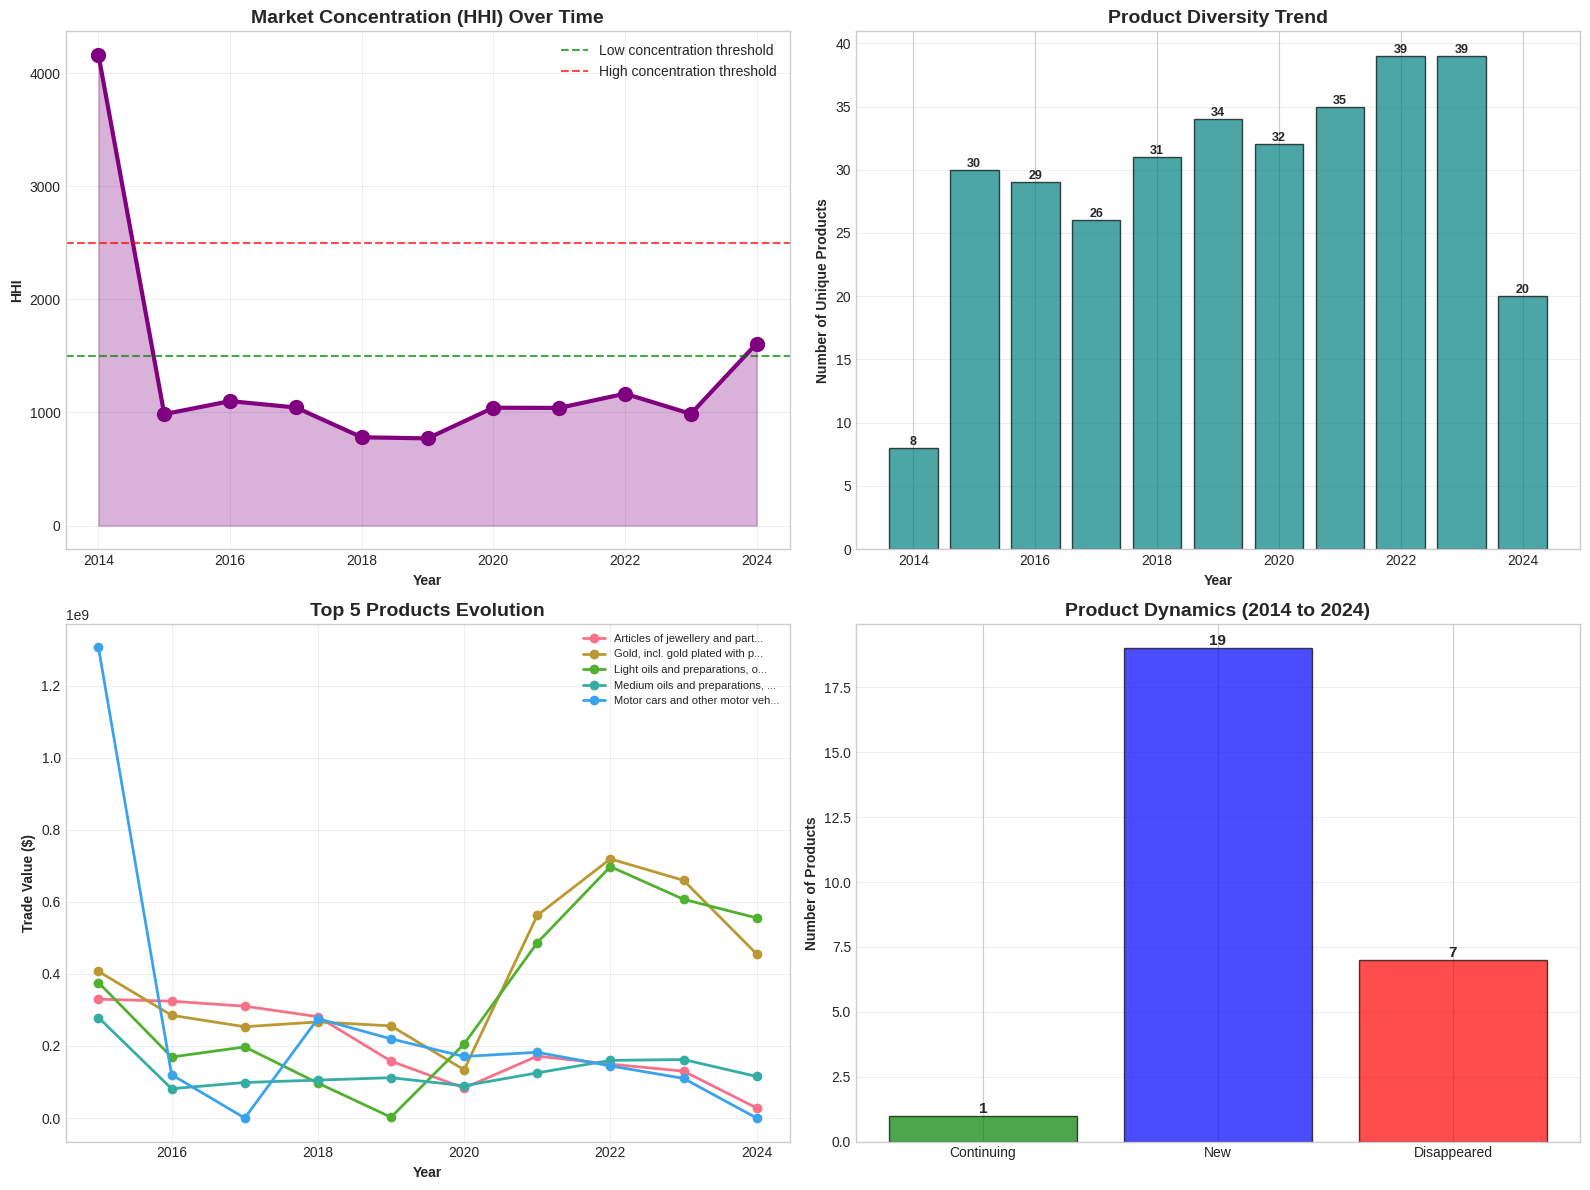


✓ Product Feature Analysis Complete!


In [21]:
# =============================================================================
# PRODUCT FEATURE ANALYSIS
# =============================================================================
print('\n' + '='*80)
print('PRODUCT FEATURE ANALYSIS')
print('='*80)

df_value = df_clean[df_clean['measure'] == 'value']

# 1. Product Concentration Analysis
print('\n1. PRODUCT CONCENTRATION ANALYSIS')
print('-'*60)

# Calculate Herfindahl-Hirschman Index (HHI) for each year
hhi_by_year = []
for year in df_value['year'].unique():
    year_data = df_value[df_value['year'] == year]
    product_shares = year_data.groupby('product_code')['trade_value'].sum()
    product_shares = product_shares / product_shares.sum()
    hhi = (product_shares ** 2).sum() * 10000
    hhi_by_year.append({'year': year, 'HHI': hhi})

hhi_df = pd.DataFrame(hhi_by_year).sort_values('year')

print('\nHerfindahl-Hirschman Index by Year:')
print(hhi_df.to_string(index=False))

avg_hhi = hhi_df['HHI'].mean()
print(f'\nAverage HHI: {avg_hhi:.0f}')
if avg_hhi < 1500:
    print('→ LOW concentration - Highly diversified trade')
elif avg_hhi < 2500:
    print('→ MODERATE concentration')
else:
    print('→ HIGH concentration - Trade dominated by few products')

# 2. Product Diversification Trend
print('\n\n2. PRODUCT DIVERSIFICATION TREND')
print('-'*60)

diversity_by_year = df_value.groupby('year')['product_code'].nunique().reset_index()
diversity_by_year.columns = ['year', 'unique_products']

print(diversity_by_year.to_string(index=False))

diversity_change = diversity_by_year['unique_products'].iloc[-1] - diversity_by_year['unique_products'].iloc[0]
print(f'\nChange in product diversity: {diversity_change:+d} products')

# 3. Top Products Evolution
print('\n\n3. TOP PRODUCTS EVOLUTION')
print('-'*60)

# Get top 10 products overall
top_products_overall = df_value.groupby('product_label')['trade_value'].sum().sort_values(ascending=False).head(10)

print('\nTop 10 Products (Overall):')
for i, (product, value) in enumerate(top_products_overall.items(), 1):
    pct = (value / df_value['trade_value'].sum()) * 100
    print(f'{i:2d}. {product[:50]:50s} ${value:>15,.0f} ({pct:5.1f}%)')

# Track top products over time
top_product_codes = df_value.groupby('product_code')['trade_value'].sum().sort_values(ascending=False).head(10).index

top_products_yearly = df_value[df_value['product_code'].isin(top_product_codes)].groupby(['year', 'product_label'])['trade_value'].sum().unstack(fill_value=0)

# 4. New vs Disappearing Products
print('\n\n4. PRODUCT ENTRY & EXIT ANALYSIS')
print('-'*60)

first_year = df_value['year'].min()
last_year = df_value['year'].max()

products_first_year = set(df_value[df_value['year'] == first_year]['product_code'].unique())
products_last_year = set(df_value[df_value['year'] == last_year]['product_code'].unique())

new_products = products_last_year - products_first_year
disappeared_products = products_first_year - products_last_year
continuing_products = products_first_year & products_last_year

print(f'Products in {first_year}: {len(products_first_year)}')
print(f'Products in {last_year}: {len(products_last_year)}')
print(f'\nNew products (entered): {len(new_products)}')
print(f'Disappeared products (exited): {len(disappeared_products)}')
print(f'Continuing products: {len(continuing_products)}')

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: HHI Trend
axes[0, 0].plot(hhi_df['year'], hhi_df['HHI'], marker='o', linewidth=3, color='purple', markersize=10)
axes[0, 0].axhline(1500, color='green', linestyle='--', label='Low concentration threshold', alpha=0.7)
axes[0, 0].axhline(2500, color='red', linestyle='--', label='High concentration threshold', alpha=0.7)
axes[0, 0].fill_between(hhi_df['year'], hhi_df['HHI'], alpha=0.3, color='purple')
axes[0, 0].set_xlabel('Year', fontweight='bold')
axes[0, 0].set_ylabel('HHI', fontweight='bold')
axes[0, 0].set_title('Market Concentration (HHI) Over Time', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Product Diversity
axes[0, 1].bar(diversity_by_year['year'], diversity_by_year['unique_products'],
              color='teal', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Year', fontweight='bold')
axes[0, 1].set_ylabel('Number of Unique Products', fontweight='bold')
axes[0, 1].set_title('Product Diversity Trend', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

for year, count in zip(diversity_by_year['year'], diversity_by_year['unique_products']):
    axes[0, 1].text(year, count, str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: Top 5 Products Over Time
if len(top_products_yearly.columns) >= 5:
    for i, col in enumerate(top_products_yearly.columns[:5]):
        axes[1, 0].plot(top_products_yearly.index, top_products_yearly[col],
                       marker='o', linewidth=2, label=col[:30]+'...', markersize=6)
    axes[1, 0].set_xlabel('Year', fontweight='bold')
    axes[1, 0].set_ylabel('Trade Value ($)', fontweight='bold')
    axes[1, 0].set_title('Top 5 Products Evolution', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=8, loc='best')
    axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Product Entry/Exit
categories = ['Continuing', 'New', 'Disappeared']
values = [len(continuing_products), len(new_products), len(disappeared_products)]
colors_cat = ['green', 'blue', 'red']

axes[1, 1].bar(categories, values, color=colors_cat, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Number of Products', fontweight='bold')
axes[1, 1].set_title(f'Product Dynamics ({first_year} to {last_year})', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(values):
    axes[1, 1].text(i, v, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print('\n✓ Product Feature Analysis Complete!')

Section D: Relationship & Correlation Analysis


RELATIONSHIP & CORRELATION ANALYSIS

1. CORRELATION BETWEEN TRADE TYPES
------------------------------------------------------------

Correlation Matrix:
trade_type  import  reexport
trade_type                  
import        1.00      0.49
reexport      0.49      1.00

Interpretation:


2. VALUE-QUANTITY RELATIONSHIP
------------------------------------------------------------

Value-Quantity Correlation by Trade Type:
Reexport: 0.232
Import: 0.204


3. TOP PRODUCT RELATIONSHIPS
------------------------------------------------------------

Strong Product Correlations (|r| > 0.5):
Product 1 Product 2  Correlation
  '870323   '870324         0.98
  '271012   '710812         0.90
  '252329   '711319         0.89
  '271019   '870324         0.89
  '271019   '870323         0.80
  '252329   '740811        -0.80
  '711319   '730890         0.77
  '870323   '870899         0.73
  '711319   '740811        -0.69
  '870324   '870899         0.59


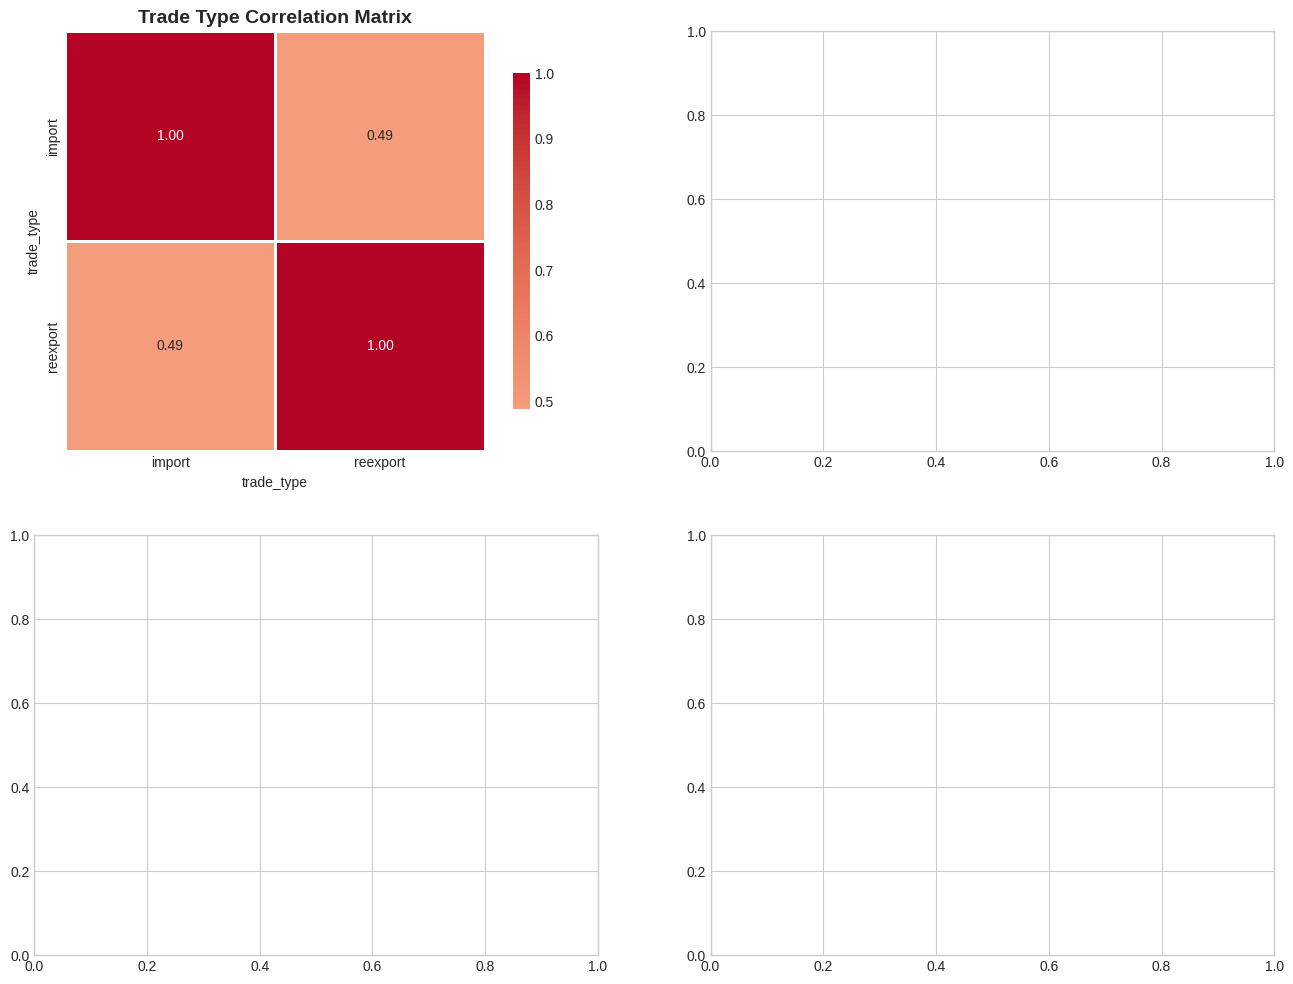

In [22]:
# =============================================================================
# RELATIONSHIP & CORRELATION ANALYSIS
# =============================================================================
print('\n' + '='*80)
print('RELATIONSHIP & CORRELATION ANALYSIS')
print('='*80)

df_value = df_clean[df_clean['measure'] == 'value']

# 1. Cross-Trade Type Correlation
print('\n1. CORRELATION BETWEEN TRADE TYPES')
print('-'*60)

# Pivot to get trade types as columns
trade_correlation_df = df_value.groupby(['year', 'trade_type'])['trade_value'].sum().unstack(fill_value=0)

# Calculate correlation matrix
correlation_matrix = trade_correlation_df.corr()

print('\nCorrelation Matrix:')
print(correlation_matrix.round(3))

# Interpret correlations
print('\nInterpretation:')
if 'export' in correlation_matrix.columns and 'import' in correlation_matrix.columns:
    exp_imp_corr = correlation_matrix.loc['export', 'import']
    print(f'Export-Import correlation: {exp_imp_corr:.3f}', end=' ')
    if exp_imp_corr > 0.7:
        print('→ STRONG positive relationship (complementary trade)')
    elif exp_imp_corr > 0.3:
        print('→ MODERATE positive relationship')
    elif exp_imp_corr > -0.3:
        print('→ WEAK relationship')
    else:
        print('→ NEGATIVE relationship')

# 2. Value-Quantity Relationship
print('\n\n2. VALUE-QUANTITY RELATIONSHIP')
print('-'*60)

# Merge value and quantity data
df_val = df_clean[df_clean['measure'] == 'value']
df_qty = df_clean[df_clean['measure'] == 'quantity']

val_qty_merge = df_val.merge(
    df_qty,
    on=['year', 'trade_type', 'product_code', 'product_label'],
    suffixes=('_val', '_qty')
)

val_qty_merge = val_qty_merge[
    (val_qty_merge['trade_value_val'] > 0) &
    (val_qty_merge['trade_value_qty'] > 0)
]

# Calculate correlation by trade type
print('\nValue-Quantity Correlation by Trade Type:')
for trade_type in val_qty_merge['trade_type'].unique():
    type_data = val_qty_merge[val_qty_merge['trade_type'] == trade_type]
    if len(type_data) > 1:
        corr = type_data['trade_value_val'].corr(type_data['trade_value_qty'])
        print(f'{trade_type.capitalize()}: {corr:.3f}')

# 3. Product Relationships
print('\n\n3. TOP PRODUCT RELATIONSHIPS')
print('-'*60)

# Get top 10 products
top_10_products = df_value.groupby('product_code')['trade_value'].sum().sort_values(ascending=False).head(10).index

# Create correlation matrix for top products
top_products_pivot = df_value[df_value['product_code'].isin(top_10_products)].pivot_table(
    index='year',
    columns='product_code',
    values='trade_value',
    fill_value=0
)

product_correlation = top_products_pivot.corr()

# Find strongest correlations (excluding diagonal)
strong_correlations = []
for i in range(len(product_correlation.columns)):
    for j in range(i+1, len(product_correlation.columns)):
        prod1 = product_correlation.columns[i]
        prod2 = product_correlation.columns[j]
        corr_val = product_correlation.iloc[i, j]
        if abs(corr_val) > 0.5:  # Only strong correlations
            strong_correlations.append({
                'Product 1': prod1,
                'Product 2': prod2,
                'Correlation': corr_val
            })

if strong_correlations:
    strong_corr_df = pd.DataFrame(strong_correlations).sort_values('Correlation', key=abs, ascending=False)
    print('\nStrong Product Correlations (|r| > 0.5):')
    print(strong_corr_df.head(10).to_string(index=False))
else:
    print('\nNo strong product correlations found.')

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Trade Type Correlation Heatmap
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
           center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0, 0])
axes[0, 0].set_title('Trade Type Correlation Matrix', fontsize=14, fontweight='bold')

# Plot 2: Scatter plot (Export vs Import)
if 'export' in trade_correlation_df.columns and 'import' in trade_correlation_df.columns:
    axes[0, 1].scatter(trade_correlation_df['export'], trade_correlation_df['import'],
                      s=100, alpha=0.6, c=range(len(trade_correlation_df)), cmap='viridis')

    # Add trend line
    z = np.polyfit(trade_correlation_df['export'], trade_correlation_df['import'], 1)
    p = np.poly1d(z)
    axes[0, 1].plot(trade_correlation_df['export'], p(trade_correlation_df['export']),
                   "r--", linewidth=2, label=f'Trend (r={exp_imp_corr:.2f})')

    axes[0, 1].set_xlabel('Exports ($)', fontweight='bold')
    axes[0, 1].set_ylabel('Imports ($)', fontweight='bold')
    axes[0, 1].set_title('Export-Import Relationship', fontsize=14, fontweight='bold')
    axes

In [12]:
print('EXECUTIVE SUMMARY')
print('='*80)
print(f'Report Date: {datetime.now().strftime("%B %d, %Y")}')
print(f'Analysis: Oman-{PARTNER_COUNTRY} Bilateral Trade')
print('='*80)

df_value = df_clean[df_clean['measure'] == 'value']

print('\n1. OVERVIEW')
print('-'*80)
print(f'Period: {df_clean["year"].min()} - {df_clean["year"].max()}')
print(f'Total Trade: ${df_value["trade_value"].sum():,.0f}')
print(f'Unique Products: {df_clean["product_code"].nunique()}')

print('\n2. KEY FINDINGS')
print('-'*80)

trade_comp = df_value.groupby('trade_type')['trade_value'].sum()
total = trade_comp.sum()
print('Trade Composition:')
for tt, val in trade_comp.items():
    pct = val/total*100
    print(f'  {tt.capitalize()}: ${val:,.0f} ({pct:.1f}%)')

oman_exp = trade_comp.get('export', 0) + trade_comp.get('reexport', 0)
oman_imp = trade_comp.get('import', 0)
bal = oman_exp - oman_imp
print(f'\nTrade Balance: ${bal:,.0f}')
print(f'Status: Oman has {"SURPLUS" if bal > 0 else "DEFICIT"} with {PARTNER_COUNTRY}')

yearly_tot = df_value.groupby('year')['trade_value'].sum()
growth = yearly_tot.pct_change().mean() * 100
print(f'Average Growth: {growth:.1f}% per year')

print('\n3. RECOMMENDATIONS')
print('-'*80)
print('1. Diversify product mix to reduce concentration')
print('2. Focus on high-growth product categories')
print('3. Strengthen trade facilitation infrastructure')
print(f'4. Monitor Oman-{PARTNER_COUNTRY} balance trends')
print('5. Explore opportunities in undertraded categories')

print('\nAnalysis Complete!')

EXECUTIVE SUMMARY
Report Date: November 18, 2025
Analysis: Oman-UAE Bilateral Trade

1. OVERVIEW
--------------------------------------------------------------------------------
Period: 2014 - 2024
Total Trade: $25,468,980,000
Unique Products: 69

2. KEY FINDINGS
--------------------------------------------------------------------------------
Trade Composition:
  Import: $19,675,080,000 (77.3%)
  Reexport: $5,793,900,000 (22.7%)

Trade Balance: $-13,881,180,000
Status: Oman has DEFICIT with UAE
Average Growth: 565.6% per year

3. RECOMMENDATIONS
--------------------------------------------------------------------------------
1. Diversify product mix to reduce concentration
2. Focus on high-growth product categories
3. Strengthen trade facilitation infrastructure
4. Monitor Oman-UAE balance trends
5. Explore opportunities in undertraded categories

Analysis Complete!
